In [1]:
# Import libraries
import pandas as pd
import pandas_ta as ta
import numpy as np
import time
from IPython.display import clear_output
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime, timedelta

In [2]:
timeframe = "hourly"
symbols = ["SPY"]
systems = ["Strat_Breakout"]#, "Strat_Breakout"]
starting_balance = 10000
risk_per_trade = 0.02 # Risking 2% per trade
exit_eod = True
last_hour = 15
last_minute = 30
volume_ratio = 1.0

In [3]:
# Load CSV File
def get_price_data(symbol, source="csv"):
    if source == "csv":
        df = pd.read_csv(f"../data/{symbol}_{timeframe}.csv", parse_dates=['Datetime'], index_col='Datetime')
    elif source == "yf":
        max_lookback = datetime.today().replace(hour=0, minute=0, second=0, microsecond=0) - timedelta(days=729)
        start_date = max_lookback.strftime('%Y-%m-%d')
        end_date = (datetime.today() + timedelta(days=1)).strftime('%Y-%m-%d')
        df = yf.download(symbol, start=start_date, end=end_date, interval="1h", multi_level_index=False)
        df = df[["Open", "High", "Low", "Close", "Volume"]]
    return df

In [4]:
def calculate_inputs(df):
        
    # Compute ATR for stop loss
    df["ATR"] = df.ta.atr(length=14)

    # Compute 50-period and 200-period EMAs
    df["EMA_50"] = df["Close"].ewm(span=50, adjust=False).mean()
    df["EMA_200"] = df["Close"].ewm(span=200, adjust=False).mean()

    # Compute 14-period average volume
    df["Avg_Vol"] = df["Volume"].rolling(window=14).mean()

    # Ensure the index is in datetime format and convert to UTC
    df.index = pd.to_datetime(df.index, utc=True).tz_convert("America/New_York")

    # Resample to daily timeframe to get previous day's high, low, and open
    resampled_df = df.resample('D').agg({'High': 'max', 'Low': 'min', 'Open': 'first'})

    # Rename 'Open' column to show it is the day's Open
    resampled_df.rename(columns={'Open': 'Open_today'}, inplace=True)

    # Shift values forward to align with the next period
    resampled_df[['High', 'Low']] = resampled_df[['High', 'Low']].shift(1)

    # Rename 'High' and 'Low' columns after shifting to show they are the previous day's values
    resampled_df.rename(columns={'High': 'High_prev', 'Low': 'Low_prev'}, inplace=True)

    # Forward fill missing values to handle non-trading days
    resampled_df.ffill(inplace=True)

    # Ensure both DataFrames have a "date" column for merging
    df['Date'] = df.index.normalize()  # Normalize to remove the time part
    resampled_df['Date'] = resampled_df.index.normalize()

    # Merge on the "Date" column
    merged_df = df.merge(resampled_df, on='Date', how='left')

    # Forward fill missing values in the merged DataFrame
    merged_df.ffill(inplace=True)

    # Restore the original DateTime index
    merged_df.set_index(df.index, inplace=True)

    # Drop the extra "Date" column if not needed
    merged_df.drop(columns=['Date'], inplace=True)
    
    return merged_df

In [5]:
def generate_signals(df, s, sl_size = 1.0, tp_ratio=1.5):

    # Get hour values
    df["Hour"] = df.index.hour

    # Entry conditions
    c1 = (df['Open_today'] < df['High_prev']) & (df['Open_today'] > df['Low_prev']) # Today's Open is inside yesterday's high and low range
    c2 = (df['Open'] < df['High_prev']) & (df['Close'] > df['High_prev']) # Breakout through yesterday's high (open below it and close above it)
    c3 = (df['Open'] > df['Low_prev']) & (df['Close'] > df['Low_prev']) & (df['Low'] < df['Low_prev']) # Price touches or dips below yesterday's Low but closes above it
    c4 = df['Hour'] != 9
    c5 = df['Hour'] != 15
    c6 = df['EMA_50'] > df['EMA_200']
    c7 = df['Volume'] > df['Avg_Vol'] * volume_ratio


    # Entries depend on the strategy
    if s == "Strat_Breakout":
        df[f"{s}_Signal"] = c1.shift(1) & c2.shift(1) & c4 & c5# & c7.shift(1)
    elif s == "Strat_Reversal":
        df[f"{s}_Signal"] = c1.shift(1) & c3.shift(1) & c4 & c6.shift(1)# & c6.shift(1)
    
    # Generate exits
    # Create atr_size: 0 if ATR is missing, otherwise use the shifted ATR
    atr_size = df['ATR'].shift(1).fillna(0)  # If ATR is NaN, use 0
    if s == "Strat_Breakout":
        # Calculate Stop Loss (SL) using np.minimum with atr_size
        df['SL'] = np.minimum(df['Low'].shift(1), df['High_prev'] - atr_size * sl_size)  # Use atr_size in the calculation
        # Calculate SL size and TP based on the SL
        sl_size = df['Open'] - df['SL']
        df['TP'] = df['Open'] + sl_size * tp_ratio

    elif s == "Strat_Reversal":
        # Calculate Stop Loss (SL) using np.minimum with atr_size
        df['SL'] = np.minimum(df['Low_prev'], df['Open'] - atr_size * sl_size)  # Use atr_size in the calculation
        # Calculate SL size and TP based on the SL
        sl_size = df['Open'] - df['SL']
        df['TP'] = df['Open'] + sl_size * tp_ratio

    return df

In [6]:
def generate_trades(df, s, starting_balance, risk_per_trade, exit_eod=False):
    #create empty list for trades
    trades_list = []
    trade_open = False
    open_change = {}
    balance = starting_balance
    equity = starting_balance
    balance_history = []
    equity_history = []
    
    #iterate through rows to work out entries and exits
    for i, row in df.iterrows():
        #if there is currently no trade
        if not trade_open:
            #check if long signal was generated at the close and enter at the same time
            if row[f"{s}_Signal"] == True:
                entry_date = i
                entry_price = row.Open
                sl = row.SL
                tp = row.TP

                # Calculate position size based on risk percentage
                risk_amount = balance * risk_per_trade
                position_size = risk_amount / abs(entry_price - sl)  # Position size in units

                trade_open = True
        #check if a trade is already open
        if trade_open:
            #get price values
            low = row.Low
            high = row.High
            # Track the open change while the trade is open to monitor balance during the trade.
            open_change[i] = low / entry_price

            # Calculate unrealized PnL
            floating_pnl = (high - entry_price) * position_size
            equity = balance + floating_pnl  # Update equity dynamically

            # Calculate unrealized PnL
            #check if stop is hit
            if low <= sl:
                #first check for a gap down
                if row.Open <= sl:
                    exit_price = row.Open
                else:
                    exit_price = sl
                trade_open = False

            # Now do the same check for take profit
            elif high >= tp:
                #first check for a gap up
                if row.Open >= tp:
                    exit_price = row.Open
                else:
                    exit_price = tp
                trade_open = False
            
            elif exit_eod and i.hour == last_hour and i.minute == last_minute:
                exit_price = row.Close  # Close at the market close price
                trade_open = False

            if not trade_open: # If trade has been closed
                exit_date = i
                trade_open = False
                pnl = (exit_price - entry_price) * position_size  # PnL in currency terms
                balance += pnl  # Update balance with PnL

                #store trade data in a list
                trade = [entry_date, entry_price, exit_date, exit_price, position_size, pnl, balance, True]
                #append trade to overall trade list
                trades_list.append(trade)

        # Store balance and equity
        balance_history.append(balance)
        equity_history.append(equity)

    trades = pd.DataFrame(trades_list, columns=["Entry_Date", "Entry_Price", "Exit_Date", "Exit_Price", "Position_Size", "PnL", "Balance", "Sys_Trade"])
    
    #calculate return of each trade as well as the trade duration
    #trades[f"{s}_Return"] = trades.Exit_Price / trades.Entry_Price
    trades[f"{s}_Return"] = trades.Balance / trades.Balance.shift(1)
    dur = []
    for i, row in trades.iterrows():
        d1 = row.Entry_Date
        d2 = row.Exit_Date
        dur.append(np.busday_count(d1.date(), d2.date()) + 1)#Add 1 because formula doesn't include the end date otherwise
    
    trades[f"{s}_Duration"] = dur

    #create a new dataframe with an index of exit dfs
    returns = pd.DataFrame(index=trades.Exit_Date)
    #create a new dataframe with an index of entries to track entry price
    entries = pd.DataFrame(index=trades.Entry_Date)

    entries[f"{s}_Entry_Price"] = pd.Series(trades.Entry_Price).values
    #add the Return column to this new data frame
    returns[f"{s}_Ret"] = pd.Series(trades[f"{s}_Return"]).values
    returns[f"{s}_Trade"] = pd.Series(trades.Sys_Trade).values
    returns[f"{s}_Duration"] = pd.Series(trades[f"{s}_Duration"]).values
    returns[f"{s}_PnL"] = pd.Series(trades.PnL).values
    returns[f"{s}_Balance"] = pd.Series(trades.Balance).values
    change_ser = pd.Series(open_change, name=f"{s}_Change")

    #add the returns from the trades to the main data frame
    df = pd.concat([df, returns, entries, change_ser], axis=1)
    #fill all the NaN return values with 1 as there was no profit or loss on those days
    df[f"{s}_Ret"] = df[f"{s}_Ret"].fillna(1)
    #fill all the NaN trade values with False as there was no trade on those days
    df[f"{s}_Trade"] = df[f"{s}_Trade"].infer_objects(copy=False)
    #fill all the NaN return values with 1 as there was no loss on those days
    df[f"{s}_Change"] = df[f"{s}_Change"].astype(float).fillna(1)
    
    #use the updated balance and equity variables
    df[f"{s}_Bal"] = pd.Series(balance_history, index=df.index).ffill()
    df[f"{s}_Equity"] = pd.Series(equity_history, index=df.index).ffill()

    active_trades = np.where(df[f"{s}_Trade"] == True, True, False)
    df[f"{s}_In_Market"] = df[f"{s}_Trade"].copy()
    #populate trades column based on duration
    for count, t in enumerate(active_trades):
        if t == True:
            dur = df[f"{s}_Duration"].iat[count]
            for i in range(int(dur)):
                #starting from the exit date, move backwards and mark each trading day
                df[f"{s}_In_Market"].iat[count - i] = True

    df.index.name = "Datetime"
    
    return df, trades

In [7]:
def backtest(price, sl, tp, exit_eod=False):

    #calculate strategy inputs
    price = calculate_inputs(price)

    for s in systems:
        #generate signals
        price = generate_signals(price, s, sl, tp)
        #generate trades
        price, trades = generate_trades(price, s, starting_balance=starting_balance, risk_per_trade=risk_per_trade, exit_eod=exit_eod)
    for s in systems:
        #calculate drawdown
        price[f"{s}_Peak"] = price[f"{s}_Bal"].cummax()
        price[f"{s}_DD"] = price[f"{s}_Bal"] - price[f"{s}_Peak"]

    return price, trades

In [8]:
results = []
prog = 0
sl_range = np.arange(1, 1.5, 0.5)
tp_range = np.arange(5, 6, 1)
max_prog = len(symbols) * len(tp_range) * len(sl_range)
start_time = time.time()
for sym in symbols:
    for tp in tp_range:
        for sl in sl_range:
            price = get_price_data(sym, source="csv")
            result, trades = backtest(price, sl, tp, exit_eod=exit_eod)
            results.append(result)
            prog += 1
            clear_output(wait=True)
            print(f"Progress: {round((prog / max_prog) * 100)} %")
end_time = time.time()
print(f"Total Time Elapsed: {end_time - start_time} s")

Progress: 100 %
Total Time Elapsed: 0.16545343399047852 s


In [9]:
#calculate metrics
def get_metrics(system, data):
    rfr = 0.03 # risk free return rate of 3%
    if timeframe == "daily":
        N = 252 # number of trading days per year
    elif timeframe == "hourly":
        N = 252 * 6.5 # number of trading hours per year (assuming 9:30 - 16:00 for NYSE)
    metrics = {}
    years = (data.index[-1] - data.index[0]).days / 365.25
    sys_return = round(((data[f"{system}_Bal"].iloc[-1]/data[f"{system}_Bal"].iloc[0]) - 1) * 100, 2)
    sys_cagr = round(((((data[f"{system}_Bal"].iloc[-1]/data[f"{system}_Bal"].iloc[0])**(1/years))-1)*100), 2)
    sys_peak = data[f"{system}_Bal"].cummax()
    sys_dd = round(((data[f"{system}_DD"] / data[f"{system}_Peak"]).min()) * 100, 2)
    rod = sys_cagr / abs(sys_dd)
    periods_in_market = data[f"{system}_In_Market"].sum()
 
    win = data[f"{system}_Ret"] > 1
    loss = data[f"{system}_Ret"] < 1
    signals = data[f"{system}_Signal"].sum()
    trades_triggered = data[f"{system}_Trade"].sum()
    tim = round(periods_in_market / len(data) * 100, 2)
    rbe = round((sys_cagr / tim) * 100, 2)
    rbeod = rbe / abs(sys_dd) # return by exposure by drawdown (assuming drawdown doesn"t scale as TIM increases. Could be wrong)
    gaps = (data.Open > data[f"{system}_Entry_Price"]).sum()
    non_gaps = (data.Open <= data[f"{system}_Entry_Price"]).sum()
    wins = win.sum()
    losses = loss.sum()
    winrate = round(wins / (wins + losses) * 100, 2)
    
    # calculate the size of the move from the entry data to the close
    ret_size = np.where(data[f"{system}_Trade"] == True, data[f"{system}_Ret"], 1)
    avg_up_move = (data[f"{system}_Ret"][data[f"{system}_Ret"] > 1].mean() - 1) * 100
    max_up_move = (data[f"{system}_Ret"].max() - 1) * 100
    avg_down_move = (data[f"{system}_Ret"][data[f"{system}_Ret"] < 1].mean() - 1) * 100
    max_down_move = (data[f"{system}_Ret"].min() - 1) * 100
    avg_rr = round(abs(avg_up_move / avg_down_move), 2)

    #sharpe ratio
    ret = data[f"{system}_Bal"].pct_change().dropna()
    excess_ret = ret - rfr/N
    sharpe = np.sqrt(N) * excess_ret.mean() / excess_ret.std()

    #sortino ratio
    downside_std = excess_ret[excess_ret < 0].std()
    sortino = np.sqrt(N) * excess_ret.mean() / downside_std
        
    #save data
    metrics["Start_Balance"] = round(data[f"{system}_Bal"].iat[0], 2)
    metrics["Final_Balance"] = round(data[f"{system}_Bal"].iat[-1], 2)
    metrics["Total_Return"] = round(sys_return, 2)
    metrics["Annual_Return"] = round(sys_cagr, 2)
    metrics["Time_in_Market"] = round(tim, 2)
    metrics["Return_By_Exposure"] = rbe
    metrics["Max_Drawdown"] = round(sys_dd, 2)
    metrics["Return_Over_Drawdown"] = round(rod, 2)
    metrics["RBE_Over_Drawdown"] = round(rbeod, 2)
    metrics["Sharpe"] = round(sharpe, 2)
    metrics["Sortino"] = round(sortino, 2)
    metrics["Signals"] = round(signals, 2)
    metrics["Trades"] = round(trades_triggered, 2)
    
    metrics["Gap"] = round(gaps)
    metrics["No_Gap"] = round(non_gaps)
    metrics["Wins"] = round(wins, 2)
    metrics["Losses"] = round(losses, 2)
    metrics["Winrate"] = round(winrate, 2)
    metrics["Max_Trade_Return_pct"] = round(max_up_move, 2)
    metrics["Max_Trade_Loss_pct"] = round(max_down_move, 2)
    metrics["Avg_Trade_Return_pct"] = round(avg_up_move, 2)
    metrics["Avg_Trade_Loss_pct"] = round(avg_down_move, 2)
    metrics["Avg_RR"] = avg_rr
    
    return metrics

In [10]:
for count, res in enumerate(results):
    sys_metrics = {}
    for s in systems:
        sys_metrics.update({s: get_metrics(s, res)})
    sys_metrics_df = pd.DataFrame.from_dict(sys_metrics)

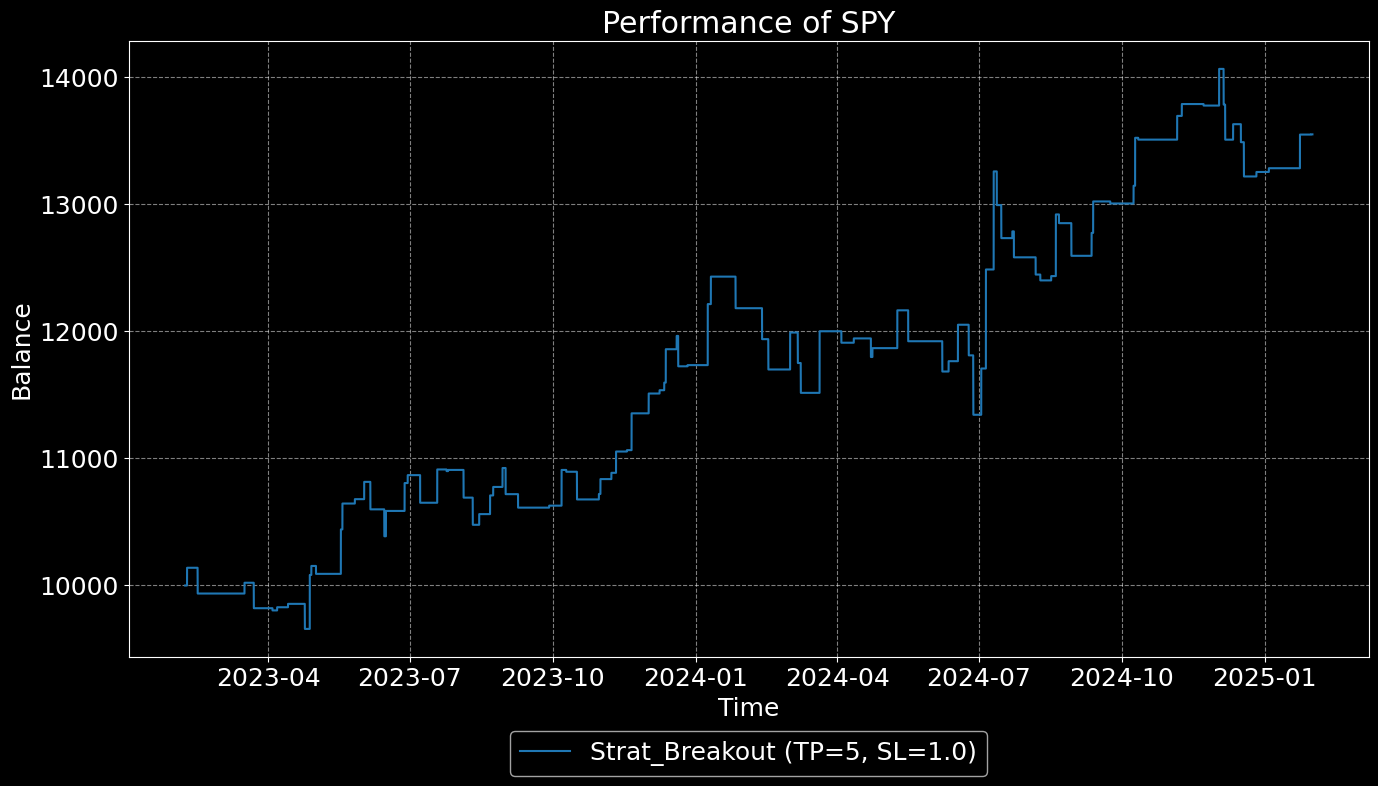

In [11]:
plt.style.use("dark_background")
plt.rcParams["figure.figsize"] = (16, 8)
plt.rcParams.update({"font.size": 18})

# Use a colormap for distinct colors
cmap = plt.get_cmap("tab10")  # You can try 'tab20', 'viridis', 'plasma', etc.

for count, sym in enumerate(symbols):
    plt.figure()
    plt.title(f"Performance of {sym}")

    legend_entries = []  # Store legend labels
    total_lines = len(tp_range) * len(sl_range) * len(systems)  # Total lines to plot
    colors = [cmap(i / total_lines) for i in range(total_lines)]  # Generate distinct colors

    color_idx = 0  # Track color index

    for tp in tp_range:
        for sl in sl_range:
            for s in systems:
                result_idx = count * len(tp_range) * len(sl_range) + list(tp_range).index(tp) * len(sl_range) + list(sl_range).index(sl)
                if result_idx >= len(results):  
                    continue  # Prevent out-of-bounds error
                label = f"{s} (TP={tp}, SL={sl})" 
                plt.plot(results[result_idx][f"{s}_Bal"], color=colors[color_idx], label=label)  # Use generated colors
                legend_entries.append(label)

                color_idx += 1  # Move to next color

    plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=2)
    plt.xlabel("Time")
    plt.ylabel("Balance")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()


In [12]:
sys_metrics_df

,Strat_Breakout
Start_Balance,10000.00
Final_Balance,13551.49
Total_Return,35.51
Annual_Return,16.55
Time_in_Market,3.02
Return_By_Exposure,548.01
Max_Drawdown,-8.75
Return_Over_Drawdown,1.89
RBE_Over_Drawdown,62.63
Sharpe,0.90


In [13]:
# Split index into 'Date' and 'Time' columns
trades['Entry_Date'] = pd.to_datetime(trades["Entry_Date"])
trades['Entry_Hour'] = trades['Entry_Date'].dt.hour
# Convert "Strat_Breakout_Return" to percentage
trades["Return_Percentage"] = (trades[f"{systems[0]}_Return"] - 1) * 100

# Group by Hour and Calculate Average PnL
hourly_return = trades.groupby("Entry_Hour")["Return_Percentage"].mean()

# Display Result
print(hourly_return)

Entry_Hour
10    0.489002
11    0.128498
12    0.282497
13    0.187151
14    0.075468
Name: Return_Percentage, dtype: float64
